In [1]:
sealed trait Nat
final object Zero extends Nat
final case class Suc(n: Nat) extends Nat
sealed trait List[+A]
final object Nil extends List[Nothing]
final case class Cons[A](head: A, tail: List[A]) extends List[A]

defined trait Nat
defined object Zero
defined class Suc
defined trait List
defined object Nil
defined class Cons

In [2]:
def length[A]: List[A] => Int = {
    case Nil => 0
    case Cons(h, t) => 1 + length(t)
} 

defined function length

In [1]:
sealed trait Ring 
case object Zero extends Ring
case object One extends Ring
case class Elem(x: Int) extends Ring
case class Add(x: Ring, y: Ring) extends Ring
case class Mult(x: Ring, y: Ring) extends Ring


defined trait Ring
defined object Zero
defined object One
defined class Elem
defined class Add
defined class Mult

In [4]:
def reduce: Ring => Ring = {
    case Zero => Zero
    case One => One
    case Elem(x) => Elem(x)
    case Add(x, y) => if (x == y) Mult(reduce(x), Elem(2)) else Add(reduce(x), reduce(y))
    case Mult(x, y) => Mult(reduce(x), reduce(y))
}

defined function reduce

In [5]:
def toInt: Ring => Int = {
    case Zero => 0
    case One => 1
    case Elem(x) => x
    case Add(x, y) => toInt(x) + toInt(y)
    case Mult(x, y) => toInt(x) * toInt(y)
}

defined function toInt

In [3]:
sealed trait RingF[+A]
case object Zero extends RingF[Nothing]
case object One extends RingF[Nothing]
case class Elem(x: Int) extends RingF[Nothing]
case class Add[A](x: A, y: A) extends RingF[A]
case class Mult[A](x:A, y: A) extends RingF[A]



defined trait RingF
defined object Zero
defined object One
defined class Elem
defined class Add
defined class Mult

In [4]:
val expresion1 = Mult(Elem(4), Add(Elem(3), One))

expresion1: Mult[Product with Serializable with RingF[Product with Serializable with RingF[Nothing]]] = Mult(Elem(4), Add(Elem(3), One))

In [5]:
def evalToInt: RingF[Int] => Int = {
    x => x match {
        case Zero => 0
        case One => 1
        case Elem(x) => x
        case Add(x, y) => x + y
        case Mult(x, y) => x * y
    }
}



defined function evalToInt

In [6]:
trait Functor[F[_]] {
    def map[A,B](f: A => B): F[A] => F[B]
}

implicit val ringFunctor = new Functor[RingF] {
    override def map[A, B](f: A => B): RingF[A] => RingF[B] = {
        case Zero => Zero
        case One => One
        case Elem(x) => Elem(x)
        case Add(x, y) => Add(f(x), f(y))
        case Mult(x, y) => Mult(f(x), f(y))
    }
}

defined trait Functor
ringFunctor: AnyRef with Functor[RingF] = ammonite.$sess.cmd5$Helper$$anon$1@1ace59ba

In [6]:
def liftInt: RingF[RingF[Int]] => RingF[Int] = {
    ringFunctor.map(evalToInt)
}

defined function liftInt

In [7]:
val rare = Add(Elem(1), Elem(2))
liftInt(rare)

rare: Add[Elem] = Add(Elem(1), Elem(2))
res6_1: RingF[Int] = Add(1, 2)

In [7]:
case class Fix[F[_]](value: F[Fix[F]] )
object Fix {
  def fix[F[_]](ff: F[Fix[F]]): Fix[F] = new Fix[F](ff)
  def unfix[F[_]]: Fix[F] => F[Fix[F]] = f => f.value
}

defined class Fix
defined object Fix

In [8]:
type Ring = Fix[RingF]
val zero = Fix[RingF](Zero)
val one =  Fix[RingF](One)
def elem: Int  => Ring = x => Fix[RingF](Elem(x))
def add: (Ring, Ring) => Ring = (x, y) =>  Fix[RingF](Add(x, y))
def mult: (Ring, Ring) => Ring = (x, y) =>  Fix[RingF](Mult(x, y))

defined type Ring
zero: Fix[RingF] = Fix(Zero)
one: Fix[RingF] = Fix(One)
defined function elem
defined function add
defined function mult

In [9]:
val s = add(elem(7), elem(7))
val exp1 = mult(elem(4), add(elem(3), one))

s: Ring = Fix(Add(Fix(Elem(7)), Fix(Elem(7))))
exp1: Ring = Fix(Mult(Fix(Elem(4)), Fix(Add(Fix(Elem(3)), Fix(One)))))

In [22]:
def cata: Fix[RingF] => Int = {
    x => (evalToInt compose ringFunctor.map(cata) compose Fix.unfix)(x)
}


defined function cata

In [23]:
cata(exp1)

res22: Int = 16

In [13]:
def cata[F[_], A](alg: F[A] => A)(implicit F: Functor[F]): Fix[F] => A = {
    x => alg(F.map(cata(alg))(Fix.unfix(x)))
}

defined function cata

In [15]:
def cata2[F[_], A](alg: F[A] => A)(implicit F: Functor[F]): Fix[F] => A = {
    x => (alg compose F.map(cata(alg)) compose Fix.unfix)(x)
}

defined function cata2

In [17]:
cata2(evalToInt)(ringFunctor)(exp1)

res20: Int = 16

In [20]:
def recursiveEvalToInt = cata(evalToInt)
recursiveEvalToInt(exp1)

defined function recursiveEvalToInt
res19_1: Int = 16

In [19]:
/**h
Repasar esto para que funcione
**/
sealed trait ListF[+A, +B]
sealed trait List[+A] extends ListF[A, Fix[List]]
final object Nil extends ListF[Nothing, Nothing]
final case class Cons[A, B](head: A, tail: B) extends ListF[A, B]

defined trait ListF
defined trait List
defined object Nil
defined class Cons

In [20]:
def findDivisorsOf(r: Int): RingF[Int] = {
    def loop(n: Int): RingF[Int] = {
        n match {
            case 0 => Zero
            case 1 => One
            case x => 
                if (x >= r) Elem(x)
                else if (r%x == 0) Mult(r/x, x) 
                else loop(n+1)
        }
    }
    loop(2)
}

defined function findDivisorsOf

In [21]:
findDivisorsOf(6)
findDivisorsOf(12)

res20_0: RingF[Int] = Mult(3, 2)
res20_1: RingF[Int] = Mult(6, 2)

In [22]:
def f1: RingF[Int] => RingF[RingF[Int]] = ringFunctor.map(findDivisorsOf)
def find: Int => RingF[RingF[Int]] = {
    x => f1(findDivisorsOf(x))
}

defined function f1
defined function find

In [23]:
find(8)

res22: RingF[RingF[Int]] = Mult(Mult(2, 2), Elem(2))

In [24]:
def ana[F[_], A](coalg: A => F[A])(implicit F: Functor[F]): A => Fix[F] = {
    x => Fix((F.map(ana(coalg))(coalg(x))))
}

defined function ana

In [25]:
val expression3 = ana(findDivisorsOf)(ringFunctor)(12)

expression3: Fix[RingF] = Fix(
  Mult(Fix(Mult(Fix(Elem(3)), Fix(Elem(2)))), Fix(Elem(2)))
)

In [26]:
def evalToStr: RingF[String] => String = {
    x => x match {
        case Zero => "0"
        case One => "1"
        case Elem(x) => x.toString
        case Add(x, y) => x.toString + " + " + y.toString
        case Mult(x, y) => x.toString + " * " + y.toString
    }
}

defined function evalToStr

In [27]:
cata(evalToStr)(ringFunctor)(ana(findDivisorsOf)(ringFunctor)(12))

res26: String = "3 * 2 * 2"

In [28]:
import $ivy.`io.github.stanch::reftree:1.3.0`

{{
  import reftree.render._, reftree.diagram._
  import reftree.contrib.SimplifiedInstances.string
  val renderer = Renderer(renderingOptions = RenderingOptions(density = 60))
    
  renderer.render("examples/example5", Diagram.sourceCodeCaption(expression3))
}}
Image.fromFile("examples/example5.png")

import $ivy.$                                



In [29]:
sealed trait ListF[+A] 
case object NilF extends ListF[Nothing]
case class ConsF[A](head: String, tail: A) extends ListF[A]

defined trait ListF
defined object NilF
defined class ConsF

In [30]:
val listOfStringFunctor = new Functor[ListF] {
 override def map[A, B](f: A => B): ListF[A] => ListF[B] = {
     case NilF => NilF
     case ConsF(h, t) => ConsF(h, f(t))
 }   
}

listOfStringFunctor: AnyRef with Functor[ListF] = ammonite.$sess.cmd29$Helper$$anon$1@3858553e

In [31]:
type ListString = Fix[ListF]
val nil = Fix[ListF](NilF)
def cons : (String, ListString) => ListString = (h, t) =>  Fix[ListF](ConsF(h, t))

defined type ListString
nil: Fix[ListF] = Fix(NilF)
defined function cons

In [32]:
val fixL1 = cons("a", cons("b", cons("c", nil)))

fixL1: ListString = Fix(ConsF("a", Fix(ConsF("b", Fix(ConsF("c", Fix(NilF)))))))

In [33]:
def length: ListF[Int] => Int = {
    case NilF => 0
    case ConsF(h, t) => t + 1
}

cata(length)(listOfStringFunctor)(fixL1)

defined function length
res32_1: Int = 3

In [34]:
val l1 = List("a", "b", "c")

l1: collection.immutable.List[String] = List("a", "b", "c")

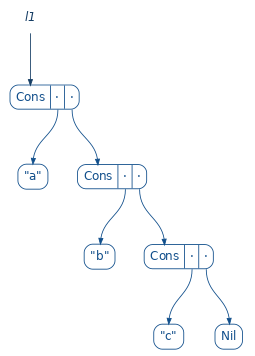

import $ivy.$                                



In [35]:
import $ivy.`io.github.stanch::reftree:1.3.0`

{{
  import reftree.render._, reftree.diagram._
  import reftree.contrib.SimplifiedInstances.string
  val renderer = Renderer(renderingOptions = RenderingOptions(density = 60))
    
  renderer.render("examples/example7", Diagram.sourceCodeCaption(l1))
}}
Image.fromFile("examples/example7.png")

In [36]:
l1.foldLeft(0)((h, t) => h + 1)

res35: Int = 3

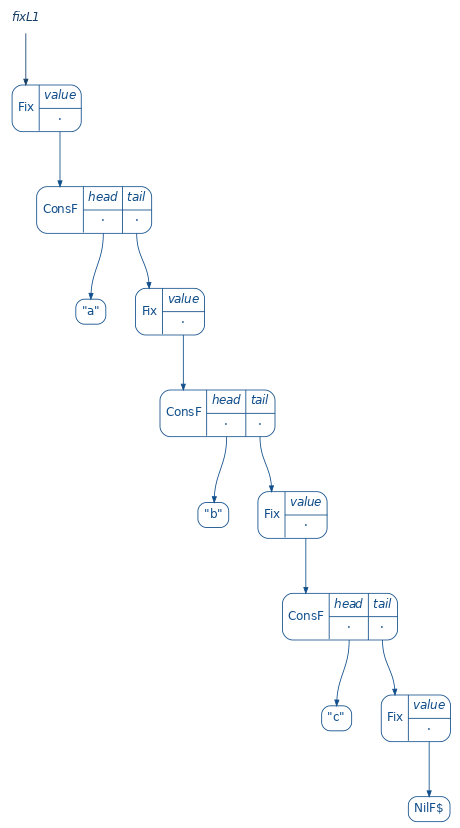

import $ivy.$                                



In [37]:
import $ivy.`io.github.stanch::reftree:1.3.0`

{{
  import reftree.render._, reftree.diagram._
  import reftree.contrib.SimplifiedInstances.string
  val renderer = Renderer(renderingOptions = RenderingOptions(density = 60))
    
  renderer.render("examples/example8", Diagram.sourceCodeCaption(fixL1))
}}
Image.fromFile("examples/example8.png")

In [38]:
def myFoldLeft[A](baseValue: A)(evaluator: (String, A) => A)(l: ListString): A = {
    def alg: ListF[A] => A = {
        case NilF => baseValue
        case ConsF(h, t) => evaluator(h, t)
        }
    cata(alg)(listOfStringFunctor)(l)

}

defined function myFoldLeft

In [39]:
myFoldLeft(0)((x, y) => y + 1)(fixL1)

res38: Int = 3

In [40]:
def hylo[A, B, F[_]](ev1: A => F[A])(ev2: F[B] => B)(implicit functor: Functor[F]): A => B = {
    x => cata(ev2)(functor)((ana(ev1)(functor)(x)))
}

defined function hylo

In [41]:
hylo(findDivisorsOf)(evalToInt)(ringFunctor)(12)

res40: Int = 12

In [42]:
def prettyPrint: RingF[String] => String = {
    case Zero => "0"
    case One => "1"
    case Elem(x: Int) => x.toString
    case Add(x, y) => x + " + " + y
    case Mult(x, y) => x + " * " + y
}

defined function prettyPrint

In [43]:
hylo(findDivisorsOf)(prettyPrint)(ringFunctor)(12)

res42: String = "3 * 2 * 2"

In [44]:
def optimize[A]: RingF[Fix[RingF]] => Fix[RingF] = {
    case Add(x, y) => if (x == y) Fix[RingF](Mult(y, Fix[RingF](Elem(2)))) else Fix[RingF](Add(x,y))
    case other => Fix[RingF](other)
}

defined function optimize

In [45]:
val a = add(add(elem(3), elem(3)), add(elem(3), elem(3)))

a: Ring = Fix(
  Add(
    Fix(Add(Fix(Elem(3)), Fix(Elem(3)))),
    Fix(Add(Fix(Elem(3)), Fix(Elem(3))))
  )
)

In [46]:
cata(prettyPrint)(ringFunctor)(cata(optimize)(ringFunctor)(a))

res45: String = "3 * 2 * 2"

In [47]:
sealed trait LList[+A, +B]
object  NilL extends LList[Nothing, Nothing]
case class ConsL[A, B](h: A, t: B) extends LList[A, B]

defined trait LList
defined object NilL
defined class ConsL

In [48]:
case class Fix2[F[_, _]](value: F[_, Fix2[F]])

defined class Fix2

In [49]:
type Mlist = Fix2[LList]
val nil = Fix2[LList](NilL)
def cons[A]: (A, Mlist) => Mlist = (x, y) => Fix2[LList](ConsL(x, y))

defined type Mlist
nil: Fix2[LList] = Fix2(ammonite.$sess.cmd46$Helper$NilL$@255e2dd)
defined function cons

In [50]:
cons("A", cons(7, nil))

res49: Mlist = Fix2(
  ConsL("A", Fix2(ConsL(7, Fix2(ammonite.$sess.cmd46$Helper$NilL$@255e2dd))))
)

In [51]:
import reftree.render._
import reftree.diagram._
import java.nio.file.Paths

val renderer = Renderer(
  renderingOptions = RenderingOptions(density = 60),
  directory = Paths.get("examples", "guide")
)
import scala.collection.immutable.Queue


import reftree.render._

import reftree.diagram._

import java.nio.file.Paths


renderer: Renderer = Renderer(
  RenderingOptions(
    0.8,
    WrappedArray(
      RGBA(0.06274509803921569, 0.3058823529411765, 0.5450980392156862, 1.0),
      RGBA(0.13333333333333333, 0.5450980392156862, 0.13333333333333333, 1.0),
      RGBA(0.803921568627451, 0.3568627450980392, 0.27058823529411763, 1.0)
    ),
    "Source Code Pro",
    60
  ),
  AnimationOptions(2 seconds, 1 second, 9, true, 0),
  examples/guide,
  "png"
)
import scala.collection.immutable.Queue


In [52]:
renderer.render("diagram2",Diagram(Queue(1)).withCaption("one") + Diagram(Queue(2)).withCaption("two"))

In [53]:
val z = mult(elem(2), add(elem(2), elem(3)))
//renderer.render("animation2", Animation.startWith(z.value).iterate(x => x).build())

z: Ring = Fix(Mult(Fix(Elem(2)), Fix(Add(Fix(Elem(2)), Fix(Elem(3))))))

In [54]:
def optimiz: RingF[Fix[RingF]] => Fix[RingF] = {
    case Add(x, y) => x match {
        case Fix(Elem(z)) => y match {
            case Fix(Elem(w)) =>Fix[RingF](Elem(z+w))
            case Fix(other) => Fix[RingF](Add(x, optimiz(y.value)))
        }
        case Fix(other) => optimiz(other)
    }
    case Mult(x, y) => x match {
        case Fix(Elem(z)) => y match {
            case Fix(Elem(w)) =>Fix[RingF](Elem(z*w))
            case Fix(other) => Fix[RingF](Mult(x, optimiz(y.value)))
        }
        case Fix(other) => optimiz(other)
    }
    case other => optimiz(other)
}

def unoptimize: RingF[Fix[RingF]] => Fix[RingF] = {
    case Elem(x) => {
        val y = findDivisorsOf(x)
        y match{ 
            case Elem(z) => elem(z)
            case Mult(a, b) => mult(elem(a), elem(b))
        }
        
    }
    case Mult(x, y) => x match {
        case Fix(Elem(z)) => mult(unoptimize(Elem(z)), y)
        //case Fix(other) => unoptimize(other)
    }
    y match {
        case Fix(Elem(z)) => unoptimize(Elem(z))
        case Fix(other) => unoptimize(other)
    }
    case other => unoptimize(other)
}

defined function optimiz
defined function unoptimize

In [55]:
def iterateoptimize(n: Int): Fix[RingF] => Fix[RingF] = {
    if (n == 0) x => optimiz(x.value)
    else x => iterateoptimize(n-1)(optimiz(x.value))
}


defined function iterateoptimize

In [56]:
val exp1 = mult(elem(4), add(elem(3), elem(1)))

exp1: Ring = Fix(Mult(Fix(Elem(4)), Fix(Add(Fix(Elem(3)), Fix(Elem(1))))))

In [57]:
renderer.render("animation", Animation.startWith(exp1).iterate(2)(x => iterateoptimize(0)(x)).build())

In [58]:
iterateoptimize(0)(z)

res57: Fix[RingF] = Fix(Mult(Fix(Elem(2)), Fix(Elem(5))))

In [59]:
unoptimize(Elem(16))

res58: Fix[RingF] = Fix(Mult(Fix(Elem(8)), Fix(Elem(2))))

In [59]:
//def foldr[A, B](l: List[A])(seed: B)(evaluator: (A, B) => B): B  = {
//    l match {
//        case Nil => seed
//        case Cons(h, t) => evaluator(h, foldr(t)(seed)(evaluator))
//    }
//}

In [60]:
def foldR[Z](e: Fix[RingF])(elem: Elem => Z)(add: (Z, Z) => Z)(mult: (Z, Z) => Z): Z = {
    e.value match {
        case Elem(x)  => elem(Elem(x))
        case Add(x, y) => add(foldR(x)(elem)(add)(mult), foldR(y)(elem)(add)(mult))
        case Mult(x, y) => mult(foldR(x)(elem)(add)(mult), foldR(y)(elem)(add)(mult))
    }
}

defined function foldR

In [61]:
a

res60: Ring = Fix(
  Add(
    Fix(Add(Fix(Elem(3)), Fix(Elem(3)))),
    Fix(Add(Fix(Elem(3)), Fix(Elem(3))))
  )
)

In [62]:
foldR[Int](a)(x => x.x)((x, y) => x + y)((x,y) => x * y)

res61: Int = 12

In [63]:
def myFoldR[Z](a: Fix[RingF])(alg: RingF [Z] => Z):Z = {
    cata(alg)(ringFunctor)(a)
}

defined function myFoldR

In [64]:
myFoldR(a)(evalToInt)

res63: Int = 12

In [65]:
trait Recursive[F[_]] extends Functor[F] {
    def cata[A](alg: F[A] => A)(x: Fix[F])(implicit F: Functor[F]): A = {
    alg(F.map(cata(alg))(Fix.unfix(x)))
    }
}

val Ring = new Recursive[RingF] {
    implicit val ff = ringFunctor
    override def map[A, B](f: A => B): RingF[A] => RingF[B] = {
        case Zero => Zero
        case One => One
        case Elem(x) => Elem(x)
        case Add(x, y) => Add(f(x), f(y))
        case Mult(x, y) => Mult(f(x), f(y))
    }
}

defined trait Recursive
Ring: AnyRef with Recursive[RingF]{implicit val ff: cmd64.this.cmd8.Functor[ammonite.$sess.cmd8.wrapper.cmd5.RingF]} = ammonite.$sess.cmd64$Helper$$anon$1@4a6d2097

In [66]:
Ring.cata(evalToInt)(a)

res65: Int = 12

In [67]:
type Alg[Z] = RingF[Z] => Z
def myAlg: Alg[Fix[RingF]] = {
            case Zero => Fix[RingF](Zero)
            case One => Fix[RingF](One)
            case Elem(x) => Fix[RingF](Elem(x))
            case Add(x, y) => Fix[RingF](Add(x, y))
            case Mult(x, y) => Fix[RingF](Mult(x, y))
        }

defined type Alg
defined function myAlg

In [68]:
trait BBEnc {
    def apply[Z](alg: Alg[Z]): Z
}

defined trait BBEnc

In [69]:
trait Iso[A, B] {
    def to(a: A): B
    def from(b: B): A
}

defined trait Iso

In [70]:
val RingIso = new Iso[Fix[RingF], BBEnc] {
    override def to(expr: Fix[RingF]): BBEnc = {
        new BBEnc {
            override def apply[Z](alg: Alg[Z]): Z = {
                cata(alg)(ringFunctor)(expr)
            }
        }
    }
    
    override def from(enc: BBEnc): Fix[RingF] = {
        def myAlg: Alg[Fix[RingF]] = {
            case Zero => Fix[RingF](Zero)
            case One => Fix[RingF](One)
            case Elem(x) => Fix[RingF](Elem(x))
            case Add(x, y) => Fix[RingF](Add(x, y))
            case Mult(x, y) => Fix[RingF](Mult(x, y))
        }
        
        enc.apply(myAlg)

    }
}

RingIso: AnyRef with Iso[Fix[RingF], BBEnc] = ammonite.$sess.cmd69$Helper$$anon$1@61c5187e

In [73]:
exp1

res72: Ring = Fix(Mult(Fix(Elem(4)), Fix(Add(Fix(Elem(3)), Fix(Elem(1))))))

In [74]:
RingIso.from(RingIso.to(exp1)) == exp1

res73: Boolean = true